In [1]:
import sys
import pandas as pd 
import numpy as np 
import unicodedata
from sklearn import linear_model
import matplotlib.pyplot as plt
from scipy.sparse import csgraph
from numpy import linalg as LA
from sklearn import decomposition
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import pyflux as pf
from sklearn.neural_network import MLPRegressor
from math import sqrt, exp

/home/aman/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Required Functions

In [44]:
# All required functions
def parseCoordinates(x):
    """
    Parse given coordinates and
    return lat, long
    """
    lat = x.split('N')[0].strip()
    longi = x.split('N')[1].strip().split('E')[0].strip()
    return float(lat), float(longi)

def getPositionAsString(x, y):
    """
    Given lat, long
    convert back to original string
    """
    return str(x) + 'N' + str(y) + 'E'

def preProcess():
    """
    Do all required one time preprocessing
    """
    global coordinates
    global LAT
    global LONG
    global NUMSITES
    global GRIDSIZE
    for i in range(1,len(lat_long)):
        coordinates.append(unicodedata.normalize('NFKD', lat_long[i]).encode('ascii','ignore'))
    for c in coordinates:
        x, y = parseCoordinates(c)
        LAT.add(x)
        LONG.add(y)
    LAT = list(LAT)
    LONG = list(LONG)
    NUMSITES = len(coordinates)
    GRIDSIZE = (len(LAT), len(LONG))
    

def getDistance(siteA, siteB):
    x0, y0 = parseCoordinates(siteA)
    x1, y1 = parseCoordinates(siteB)
    return sqrt((x0 - x1)*(x0 - x1) + (y0 - y1)*(y0 - y1))

def getEigenDistance(A, B):
    return sqrt((A[0] - B[0])*(A[0] - B[0]) +
         (A[1] - B[1])*(A[1] - B[1]) + 
         (A[2] - B[2])*(A[2] - B[2]))

def LinearRegressionHelper(siteToPredict, Neighbours, numTrain, numTest, scaleByDistance=False):
    if len(Neighbours) == 0:
        print "No neighbour to perform Linear Regression"
        return None, None
    X = pd.DataFrame()
    for n in Neighbours:
        X[n] = Df[n]
    Xt = X.head(numTrain)
    Yt = Df[siteToPredict].head(numTrain)
    Xt = np.array(Xt)
    Yt = np.array(Yt)
    #Remove 0 data values from training
    NonZeros = [i for i in range(0, len(Yt)) if Yt[i] != 0]
    Xtrain, Ytrain = Xt[NonZeros], Yt[NonZeros]
    #Train linear regression
    Reg = linear_model.LinearRegression()
    Reg.fit(Xtrain, Ytrain)
    Distances = []
    for i in range(0, len(Neighbours)):
        Distances.append(getDistance(siteToPredict, Neighbours[i]))
    #plt.scatter(Distances, abs(Reg.coef_), c='blue', marker='o', label='original')
    if scaleByDistance:
        #print len(Neighbours)
        assert (len(Neighbours) == len(Reg.coef_))
        for i in range(0, len(Reg.coef_)):
            Reg.coef_[i] = float(Reg.coef_[i])/exp(getDistance(siteToPredict, Neighbours[i]))
        #plt.scatter(Distances, abs(Reg.coef_), c='red', marker='o', label='scaled')
    #plt.legend()
    #plt.show()
    #Test accuracy
    Xtest = X.tail(numTest)
    Y_actual = Df[siteToPredict].tail(numTest)
    Y_predicted = Reg.predict(Xtest)
    return Y_actual, Y_predicted

def NNRegressionHelper(siteToPredict, Neighbours, numTrain, numTest):
    if len(Neighbours) == 0:
        print "No neighbour to perform Linear Regression"
        return None, None
    X = pd.DataFrame()
    for n in Neighbours:
        X[n] = Df[n]
    Xt = X.head(numTrain)
    Yt = Df[siteToPredict].head(numTrain)
    Xt = np.array(Xt)
    Yt = np.array(Yt)
    #Remove 0 data values from training
    NonZeros = [i for i in range(0, len(Yt)) if Yt[i] != 0]
    Xtrain, Ytrain = Xt[NonZeros], Yt[NonZeros]
    #Train linear regression
    Reg = MLPRegressor((8,4), 'relu', 'lbfgs',shuffle=False)
    Reg.fit(Xtrain, Ytrain)
    #Test accuracy
    Xtest = X.tail(numTest)
    Y_actual = Df[siteToPredict].tail(numTest)
    Y_predicted = Reg.predict(Xtest)
    return Y_actual, Y_predicted

def simpleLinearRegression(latitude, longitude, neighbourThresh, numTrain, numTest, scaleByDistance=False):
    """
    Perform simple Linear Regression for
    given site considering neighbours within
    given threshold. Return actual, predicted
    """
    #Get neighbours
    Neighbours = []
    siteToPredict = None
    for c in coordinates:
        x, y = parseCoordinates(c)
        if x == latitude and y == longitude:
            siteToPredict = c
            continue;
        if abs(x - latitude) <= neighbourThresh and abs(y - longitude) <= neighbourThresh:
            Neighbours.append(c)
    #print "Number of neighbours :", len(Neighbours)
    #Do linear regression
    return LinearRegressionHelper(siteToPredict, Neighbours, numTrain, numTest, scaleByDistance) 

def plotScatter(X, Y, xlabel, ylabel):
    """
    Plot scatter plot b/w X and Y
    """
    plt.scatter(X, Y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def getAdjacencyAndDegreeMatrix(thresh):
    """
    Return an adjacency and degree matrix
    using correlation values above thresh
    """
    #Correlation Matrix
    Correlation = np.zeros((NUMSITES, NUMSITES))
    Corr = Df.loc[:, Df.columns[1]:].corr()
    for i in range(1, len(lat_long)):
        for j in range(1, len(lat_long)):
            Correlation[i - 1][j-1] = Corr[lat_long[i]][lat_long[j]]
    #Adjacency Matrix
    A = [[0 if x <= thresh else x for x in row] for row in Correlation]
    for i in range(0, len(A)):
        A[i][i] = 0
    #Degree Matrix
    D = np.zeros((NUMSITES, NUMSITES))
    for i in range(0, len(D)):
        D[i][i] = sum(A[i])
    return A, D

def getLaplacian(thresh):
    """
    Return Laplacian of the graph considering
    correaltion above thres as edge weight
    """
    A, D = getAdjacencyAndDegreeMatrix(thresh)
    return D - A

def numCC(adj):
    """
    Given adjacency matrix of graph
    return no. of connected componenets
    """
    return csgraph.connected_components(A, directed=False)[0]

def eigenDecomp(M):
    """
    Return eigen decomposition of matrix M
    """
    return LA.eig(M)

def visualizeEigen(v, num):
    """
    Given set of eigen values v
    visulaize num'th of them
    """
    Intensity = np.zeros(GRIDSIZE)
    for c, val in zip(coordinates, v[:,num]):
        lat ,lon = parseCoordinates(c)
        l, r = LAT.index(lat), LONG.index(lon)
        Intensity[l][r] = val
    #Remove negative values by scaling
    Min = np.min(Intensity)
    for i in range(0, GRIDSIZE[0]):
        for j in range(0, GRIDSIZE[1]):
            if (Intensity[i][j] != 0):
                Intensity[i][j] = (Intensity[i][j] + abs(Min))*100 + 5.0
    #print Intensity
    #Plot intensity
    plt.imshow(Intensity)
    plt.colorbar()
    plt.show()
    #Plot eigen values
    values = list(v[:,num])
    values.sort()
    plt.plot(values)
    plt.xlabel('Sites')
    plt.ylabel('EigenValues')
    plt.show()

def visualizeEigen3D(v1, v2, v3):
    """
    Use same visualization with 3 eigen vectors
    """
    X = (v1 - np.min(v1))/(np.max(v1) - np.min(v1))
    Y = (v2 - np.min(v2))/(np.max(v2) - np.min(v2))
    Z = (v3 - np.min(v3))/(np.max(v3) - np.min(v3))
    threeD = plt.figure().gca(projection='3d')
    threeD.scatter(X, Y, Z)
    plt.show()

def Clustering(v1, v2, v3, numClusters, visualize=True):
    """
    Use given eigen vectors to form
    clusters. Plot them and return labels
    """
    X = np.zeros((NUMSITES, 3))
    X = zip(v1, v2, v3)
    X = np.array(X)
    kmeans = KMeans(n_clusters=numClusters, random_state=0).fit(X)
    Labels = kmeans.labels_
    if visualize:
        threeD = plt.figure().gca(projection='3d')
        threeD.scatter(X[:,0], X[:,1], X[:,2], c=Labels.astype(np.float), edgecolor='k')
        plt.show()
    return Labels

def LinearRegressionOnCluster(labels, latitude, longitude, numTrain, numTest, eigenSpace, numNeighbours):
    """
    Instead of spacial neighbours
    use cluster for linear regression
    """
    #Get label of required site
    assert(len(coordinates) == len(labels))
    lab, Pos = None, None
    siteToPredict = None
    for i in range(0, len(coordinates)):
        x, y = parseCoordinates(coordinates[i])
        if x == latitude and y == longitude:
            Pos = i
            siteToPredict = coordinates[i]
            break
    lab = labels[Pos]
    if Pos == None or lab == None or siteToPredict == None:
        print "Unable to get label", latitude, longitude
        return
    #Get neighbours using Labels
    """"
    Neighbours = []
    for i in range(0, len(labels)):
        if i != Pos and labels[i] == lab:
            Neighbours.append(coordinates[i])
    """
    #Get neighbours using eigenSpace
    Distances, Neighbours = [], []
    myPos = eigenSpace[Pos]
    for n in range(0, len(eigenSpace)):
        if n != Pos:
            currPos = eigenSpace[n]
            dist = sqrt((myPos[0] - currPos[0])*(myPos[0] - currPos[0]) + 
                        (myPos[1] - currPos[1])*(myPos[1] - currPos[1]) + 
                        (myPos[2] - currPos[2])*(myPos[2] - currPos[2]))
            Distances.append((dist, n))
    Distances.sort()
    for i in range(0, min(numNeighbours, len(Distances))):
        idx = Distances[i][1]
        Neighbours.append(coordinates[idx])
    #Do linear regression
    return LinearRegressionHelper(siteToPredict, Neighbours, numTrain, numTest)

def NNRegressionOnCluster(labels, latitude, longitude, numTrain, numTest):
    """
    Instead of spacial neighbours
    use cluster for linear regression
    """
    #Get label of required site
    assert(len(coordinates) == len(labels))
    lab, Pos = None, None
    siteToPredict = None
    for i in range(0, len(coordinates)):
        x, y = parseCoordinates(coordinates[i])
        if x == latitude and y == longitude:
            Pos = i
            siteToPredict = coordinates[i]
            break
    lab = labels[Pos]
    if Pos == None or lab == None or siteToPredict == None:
        print "Unable to get label", latitude, longitude
        return
    #Get neighbours
    Neighbours = []
    for i in range(0, len(labels)):
        if i != Pos and labels[i] == lab:
            Neighbours.append(coordinates[i])
    #Do NN regression
    return NNRegressionHelper(siteToPredict, Neighbours, numTrain, numTest)

def Compare(labels,thresh,eS,Neighbours,scaleByDistance=False):
    """
    Compare clustering based regression
    and spatial neighbours regression
    """
    spatial = []
    clustering = []
    test, train = 4000, 16000
    for site in coordinates:
        x, y = parseCoordinates(site)
        #Clustering
        actual, predicted = LinearRegressionOnCluster(labels, x, y, train, test,eS,Neighbours)
        clustering.append(r2_score(actual, predicted))
        #Spatial
        actual, predicted = simpleLinearRegression(x, y, thresh, train, test, scaleByDistance)
        spatial.append(r2_score(actual, predicted))
    print "Mean of spatial regression ", np.mean(spatial)
    print "Mean of spectral regression ", np.mean(clustering)
    #Plot r2 scores
    plt.scatter(range(1, NUMSITES+1), spatial, c='red', marker='o', label='spatial')
    plt.scatter(range(1, NUMSITES+1), clustering, c='blue', marker='o', label='spectral')
    plt.legend()
    plt.xlabel("Sites")
    plt.ylabel("R2 Score")
    plt.show()

def CompareWithNN(labels):
    """
    Compare clustering based regression
    and spatial neighbours regression
    """
    NN = []
    linear = []
    test, train = 4000, 16000
    for site in coordinates:
        x, y = parseCoordinates(site)
        #linear
        actual, predicted = LinearRegressionOnCluster(labels, x, y, train, test)
        linear.append(r2_score(actual, predicted))
        #NN
        actual, predicted = NNRegressionOnCluster(labels, x, y, train, test)
        NN.append(r2_score(actual, predicted))
    print "Mean of linear regression ", np.mean(linear)
    print "Mean of NN regression ", np.mean(NN)
    #Plot r2 scores
    plt.scatter(range(1, NUMSITES+1), linear, c='red', marker='o', label='linear')
    plt.scatter(range(1, NUMSITES+1), NN, c='blue', marker='o', label='NN')
    plt.legend()
    plt.xlabel('Sites')
    plt.ylabel('R2 Score')
    plt.show()
    
# ARIMA Model

def getTS(latitude, longitude):
    """
    Return Time Series data for given co-ordinates
    """
    ts = pd.DataFrame()
    for c in coordinates:
        x, y = parseCoordinates(c)
        if x == latitude and y == longitude:
            ts['time_series']=Df[c]
            break
    ts['DATE'] = pd.to_datetime(Df['DATE'])
    ts.set_index('DATE',inplace=True)
    return ts

def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=96)
    rolstd = pd.rolling_std(timeseries, window=96)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput 
    
def forecasts(Actuals, numTest, coeff) :
    pre_error = 0
    predictions = []
    for i in range(1,numTest):
        curr_diff_value = coeff[0] + coeff[1]*Actuals.diff_time_series[i-1] + coeff[2]*pre_error
        curr_predicted_value = Actuals.time_series[i-1] + curr_diff_value
        #curr_actual_value=curr_diff_value
        if curr_predicted_value < 0 :
            curr_predicted_value = 0.5*Actuals.time_series[i-1]
        predictions.append(curr_predicted_value)
        #pre_error = curr_predicted_value - Actuals.time_series[i]
    return predictions

def LearnARIMA(latitude, longitude, numTrain, numTest):
    """
    Return ARIMA predictions for given site
    for given TEST and TRAIN
    """
    Ts = getTS(latitude, longitude)
    Ts['diff_time_series'] =  (Ts.time_series - Ts.time_series.shift(1)).fillna(0)
    model = pf.ARIMA(data=Ts.head(numTrain), ar=1, ma=1, integ=1, target='diff_time_series')
    x = model.fit("MLE")
    YTest = Ts.tail(numTest)
    YTest.reset_index(inplace=True)
    YPredict = forecasts(YTest, numTest, list(x.results.x))
    return YTest['time_series'][1:], YPredict

def ARIMAwithClusters(latitude, longitude, labels, numTrain, numTest, eigenSpace, numNeighbours):
    """
    Instead of actual value use ARIMA
    predicted value in LinearRegressionOnCluster
    """
    #Get label of required site
    assert(len(coordinates) == len(labels))
    lab, Pos = None, None
    siteToPredict = None
    for i in range(0, len(coordinates)):
        x, y = parseCoordinates(coordinates[i])
        if x == latitude and y == longitude:
            Pos = i
            siteToPredict = coordinates[i]
            break
    lab = labels[Pos]
    if Pos == None or lab == None or siteToPredict == None:
        print "Unable to get label", latitude, longitude
        return

    #Get neighbours
    #Neighbours = []
    #for i in range(0, len(labels)):
    #    if i != Pos and labels[i] == lab:
    #        Neighbours.append(coordinates[i])
            
    #Get neighbours using eigenSpace
    Distances, Neighbours = [], []
    myPos = eigenSpace[Pos]
    for n in range(0, len(eigenSpace)):
        if n != Pos:
            currPos = eigenSpace[n]
            dist = sqrt((myPos[0] - currPos[0])*(myPos[0] - currPos[0]) + 
                        (myPos[1] - currPos[1])*(myPos[1] - currPos[1]) + 
                        (myPos[2] - currPos[2])*(myPos[2] - currPos[2]))
            Distances.append((dist, n))
    Distances.sort()
    for i in range(0, min(numNeighbours, len(Distances))):
        idx = Distances[i][1]
        Neighbours.append(coordinates[idx])
    #Do linear regression
    if len(Neighbours) == 0:
        print "No neighbour to perform Linear Regression"
        return
    X = pd.DataFrame()
    for n in Neighbours:
        X[n] = Df[n]
    Xt = X.head(numTrain)
    Yt = Df[siteToPredict].head(numTrain)
    Xt = np.array(Xt)
    Yt = np.array(Yt)
    #Remove 0 data values from training
    NonZeros = [i for i in range(0, len(Yt)) if Yt[i] != 0]
    Xtrain, Ytrain = Xt[NonZeros], Yt[NonZeros]
    #Train linear regression
    Reg = linear_model.LinearRegression()
    Reg.fit(Xtrain, Ytrain)
    #Use ARIMA to predict Neighbours
    Xtest = pd.DataFrame()
    for n in Neighbours:
        x, y = parseCoordinates(n)
        actual, predicted = LearnARIMA(x, y, numTrain, numTest)
        Xtest[n] = predicted
    #Now Predict for site using regression
    Y_actual = Df[siteToPredict].tail(numTest)
    Y_predicted = Reg.predict(Xtest)
    return Y_actual[1:], Y_predicted


# Data Reading and Pre-Processing

In [3]:
# Read data and Do one time Pre-Processing
Df = pd.read_excel('./Tunga_Bhadra River Basin Rainfall Data (1).xls')
lat_long = Df.columns
coordinates = []
LAT, LONG = set(), set()
NUMSITES = None
GRIDSIZE = (None, None)
preProcess()

In [4]:
Df.head(10)

,DATE,12.625N75.125E,12.625N75.375E,12.625N75.625E,12.625N75.875E,12.625N76.125,12.625N76.375,12.625N76.625E,12.875N75.125E,12.875N75.375E,...,15.125N76.125E,15.125N76.375E,15.125N76.675E,15.375N75.125E,15.375N75.375E,15.375N75.626E,15.375N75.875E,15.375N76.125E,15.375N76.375E,15.375N76.625E
0,1951-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1951-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1951-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1951-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1951-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1951-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1951-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1951-01-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1951-01-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1951-01-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# All Main logic starts from here

## Simple Linear Regression

0.951684044977


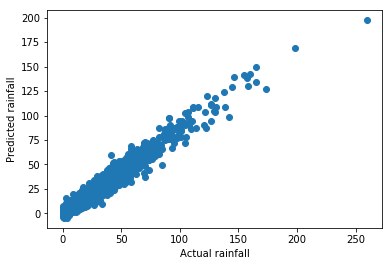

In [5]:
# First lets perform simple neghbour based linear regression
actual, predicted = simpleLinearRegression(12.625, 75.125, 0.25, 14000, 6000, True)
print r2_score(actual, predicted)
plotScatter(actual, predicted, 'Actual rainfall', 'Predicted rainfall')

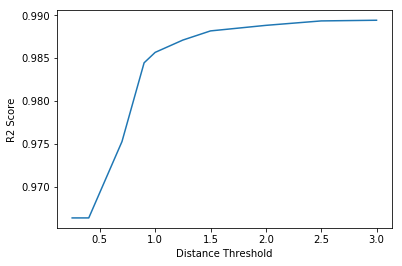

In [7]:
# Plot r2score fo different threshold values
scores = []
THRESHOLDS = [0.25, 0.4, 0.7, 0.9, 1.0, 1.25, 1.5, 2.0, 2.5, 3.0]
for th in THRESHOLDS:
    actual, predicted = simpleLinearRegression(12.625, 75.125, th, 14000, 6000)
    scores.append(r2_score(actual, predicted))
plt.plot(THRESHOLDS, scores)
plt.xlabel('Distance Threshold')
plt.ylabel('R2 Score')
plt.show()

## Spectral Clustering

In [12]:
A, D = getAdjacencyAndDegreeMatrix(0.5)
L = D - A
print "Number of connected components : ", numCC(A)
w, v = eigenDecomp(L)

Number of connected components :  1


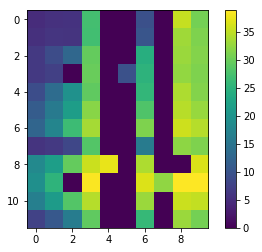

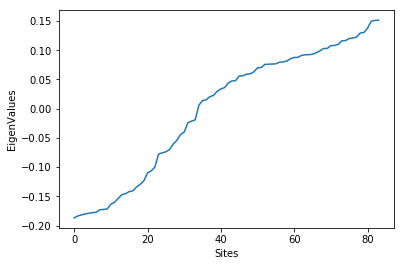

In [13]:
# Projection on first non-zero eigen vector
visualizeEigen(v, 1)

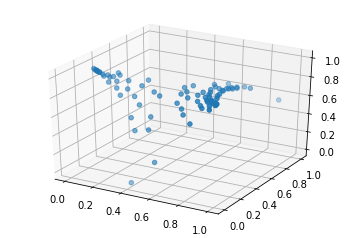

In [17]:
# Visualize projection on first thee non-zero eigen vectors
visualizeEigen3D(v[:,1], v[:,2], v[:,3])

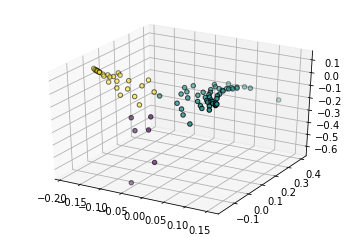

In [18]:
# Apply Kmeans to form clusters
Labels = Clustering(v[:,1], v[:,2], v[:,3], 3)

In [ ]:
# Use Linear Regression on cluster neighbours
actual, predicted = LinearRegressionOnCluster(Labels, 12.625, 75.125, 14000, 6000)
print r2_score(actual, predicted)
plotScatter(actual, predicted, 'Actual rainfall', 'Predicted rainfall')

0.969275070775


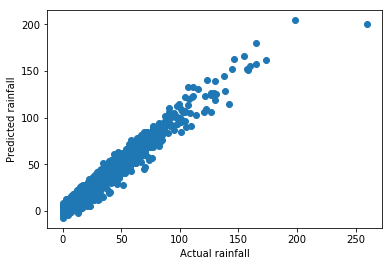

In [24]:
eS = zip(v[:,1], v[:, 2], v[:, 3])
actual, predicted = LinearRegressionOnCluster(Labels, 12.625, 75.125, 14000, 6000, eS, 5)
print r2_score(actual, predicted)
plotScatter(actual, predicted, 'Actual rainfall', 'Predicted rainfall')

0.986062323284


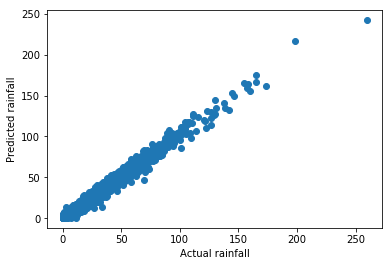

In [21]:
# Use NN Regression on cluster neighbours
actual, predicted = NNRegressionOnCluster(Labels, 12.625, 75.125, 14000, 6000)
print r2_score(actual, predicted)
plotScatter(actual, predicted, 'Actual rainfall', 'Predicted rainfall')

In [ ]:
# Compare NN and linear regression
CompareWithNN(Labels)

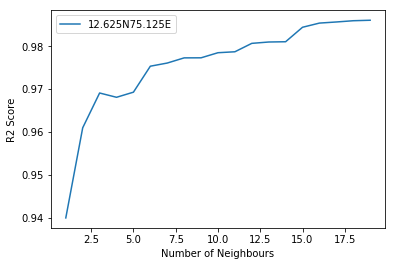

In [31]:
# Plot r2_scores for different number of clusters
scores = []
MAXN = 20
for k in range(1, MAXN):
    actual, predicted = LinearRegressionOnCluster(labels, 12.625, 75.125, 14000, 6000,eS,k)
    scores.append(r2_score(actual, predicted))
plt.plot(range(1, MAXN), scores,label="12.625N75.125E")
plt.xlabel('Number of Neighbours')
plt.ylabel('R2 Score')
plt.legend()
plt.show()
#plotScatter(range(1, MAXCLUSTERS), scores, 'Number of Clusters', 'R2score')

Mean of spatial regression  0.928625527773
Mean of spectral regression  0.955801267761


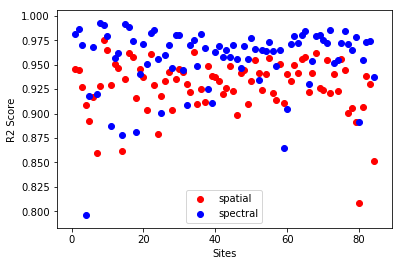

In [45]:
# Compare simple regression with cluster based
Compare(Labels,0.25,eS,12,True)  #Clustering dominates

Mean of spatial regression  0.962365227394
Mean of spectral regression  0.970439020644


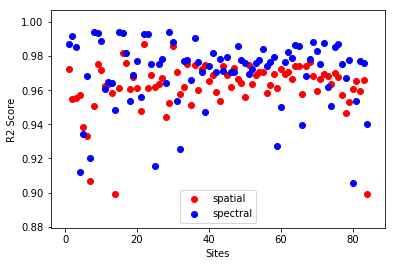

In [50]:
Compare(Labels, 0.9,eS,20,True)  #Spatial dominates

# ARIMA Model

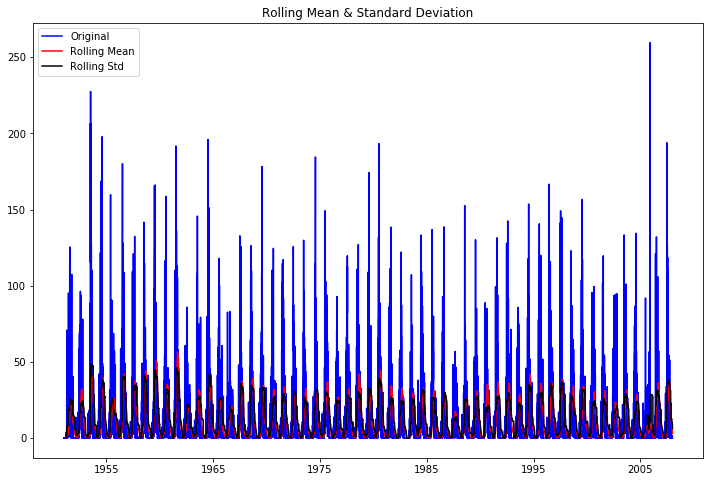

Results of Dickey-Fuller Test:
Test Statistic                -1.338939e+01
p-value                        4.800963e-25
#Lags Used                     3.100000e+01
Number of Observations Used    2.078700e+04
Critical Value (5%)           -2.861679e+00
Critical Value (1%)           -3.430665e+00
Critical Value (10%)          -2.566844e+00
dtype: float64


In [51]:
x, y = parseCoordinates(coordinates[1])
Ts = getTS(x, y)
test_stationarity(Ts.time_series)

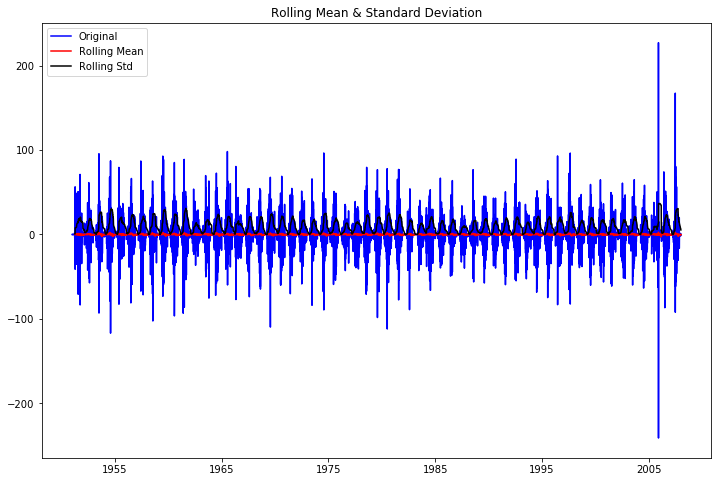

Results of Dickey-Fuller Test:
Test Statistic                   -33.193816
p-value                            0.000000
#Lags Used                        36.000000
Number of Observations Used    20782.000000
Critical Value (5%)               -2.861679
Critical Value (1%)               -3.430665
Critical Value (10%)              -2.566844
dtype: float64


In [52]:
# Difference Time series to make it stationary
Ts['diff_time_series'] =  (Ts.time_series - Ts.time_series.shift(1)).fillna(0)
test_stationarity(Ts.diff_time_series)

In [53]:
# ACF and PACF
lag_acf = acf(Ts.diff_time_series, nlags=5)
lag_pacf = pacf(Ts.diff_time_series, nlags=5, method='ols')

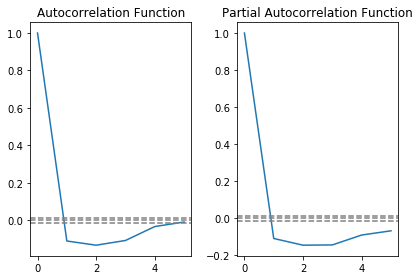

In [54]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Ts.diff_time_series)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Ts.diff_time_series)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Ts.diff_time_series)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Ts.diff_time_series)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

### Above Observations suggests AR to be 1 and MA to be 1

## ARIMA(1, 1, 1)

In [55]:
TRAIN, TEST = 16000, 4000
model = pf.ARIMA(data=Ts.head(TRAIN), ar=1, ma=1, integ=1, target='diff_time_series')

In [56]:
x = model.fit("MLE")
print list(x.results.x)[:3]
x.summary()

[-0.0002600956329273742, -0.16573933321480772, -0.94666381553827894]
Normal ARIMA(1,1,1)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced diff_time_series        Method: MLE                                       
Start Date: 1951-01-02 00:00:00                         Log Likelihood: -62790.8611                       
End Date: 1994-10-21 00:00:00                           AIC: 125589.7221                                  
Number of observations: 15998                           BIC: 125620.443                                   
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 -0.0003    0.0045     -0.0582  0.9

In [57]:
# Prediction
YTest = Ts.tail(TEST)
YTest.reset_index(inplace=True)
YPredict = forecasts(YTest, TEST, list(x.results.x))
YTest = YTest.ix[1:]
YTest['predictions'] = YPredict

0.58448888806


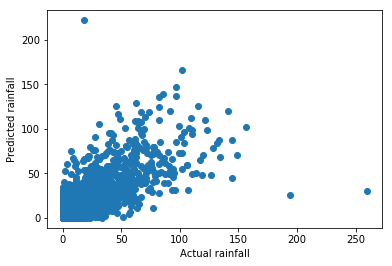

In [58]:
# Scatter Plot
print r2_score(YTest.time_series, YTest.predictions)
plotScatter(YTest.time_series, YTest.predictions, 'Actual rainfall', 'Predicted rainfall')

In [61]:
x, y = parseCoordinates(coordinates[1])
actual, predicted = ARIMAwithClusters(x, y, Labels, 16000, 4000,eS,5)

0.545684325429


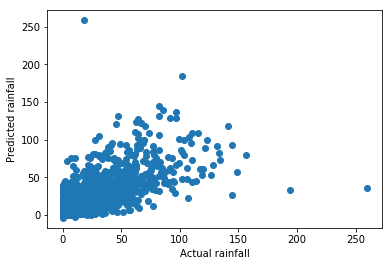

In [62]:
print r2_score(actual, predicted)
plotScatter(actual, predicted, 'Actual rainfall', 'Predicted rainfall')

In [63]:
x, y = parseCoordinates(coordinates[1])
actual, predicted = ARIMAwithClusters(x, y, Labels, 16000, 4000, eS, 10)

0.56750301402


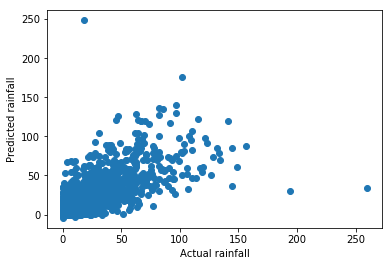

In [64]:
print r2_score(actual, predicted)
plotScatter(actual, predicted, 'Actual rainfall', 'Predicted rainfall')

### Compare ARIMA and ARIMA with Clusters

In [66]:
ARIMAscores, ARIMAwithCscores = [], []
TRAIN, TEST = 16000, 4000
for c in coordinates:
    #print c
    x, y = parseCoordinates(c)
    #ARIMA
    actual, predicted = LearnARIMA(x, y, TRAIN, TEST)
    ARIMAscores.append(r2_score(actual, predicted))
    #With Clusters
    actual, predicted = ARIMAwithClusters(x, y, Labels, TRAIN, TEST,eS,5)
    ARIMAwithCscores.append(r2_score(actual, predicted))

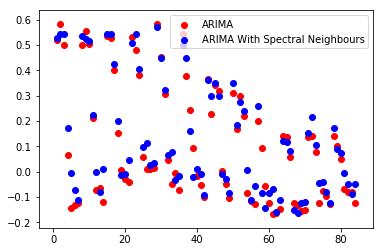

In [67]:
plt.scatter(range(1, NUMSITES+1), ARIMAscores, c='red', marker='o', label='ARIMA')
plt.scatter(range(1, NUMSITES+1), ARIMAwithCscores, c='blue', marker='o', label='ARIMA With Spectral Neighbours')
plt.xlabel('Sites')
plt.ylabel('R2 Scores')
plt.legend()
plt.show()

In [218]:
print np.mean(ARIMAscores)
print np.mean(ARIMAwithCscores)

0.110399489248
0.111873208805


In [28]:
ARIMAscores, ARIMAwithCscores = [], []
TRAIN, TEST = 16000, 4000
for c in coordinates:
    #print c
    x, y = parseCoordinates(c)
    #ARIMA
    actual, predicted = LearnARIMA(x, y, TRAIN, TEST)
    ARIMAscores.append(r2_score(actual, predicted))
    #With Clusters
    actual, predicted = ARIMAwithClusters(x, y, Labels, TRAIN, TEST, eS, 5)
    ARIMAwithCscores.append(r2_score(actual, predicted))

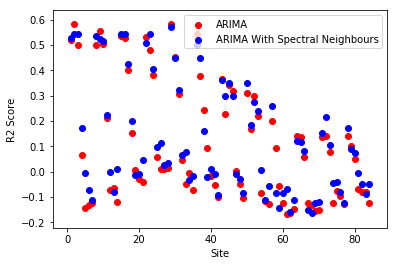

In [156]:
plt.scatter(range(1, NUMSITES+1), ARIMAscores, c='red', marker='o', label='ARIMA')
plt.scatter(range(1, NUMSITES+1), ARIMAwithCscores, c='blue', marker='o', label='ARIMA With Spectral Neighbours')
plt.xlabel('Site')
plt.ylabel('R2 Score')
plt.legend()
plt.show()

In [30]:
print np.mean(ARIMAscores)
print np.mean(ARIMAwithCscores)

0.110399489248
0.131414162326


In [118]:
D = []
for i in range(0, len(coordinates)):
    for j in range(i+1, len(coordinates)):
        geo = getDistance(coordinates[i], coordinates[j])
        ed = getEigenDistance(eS[i], eS[j])
        D.append((ed, i, j))
        
D.sort(reverse=True)
print D[20],D[-1]

(0.7181014113498257, 48, 77) (0.0009656624422901459, 15, 28)


In [148]:
coordinates[28]

'13.625N75.125E'

In [153]:
x, y = 10,11
print getDistance(coordinates[x], coordinates[y]), getEigenDistance(eS[x], eS[y])
print Labels[x], Labels[y]

0.25 0.23799080665
2 1


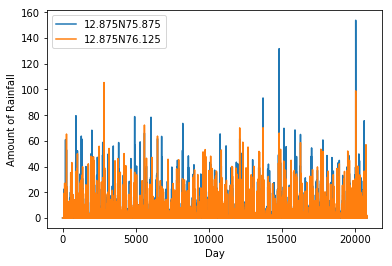

In [154]:
plt.plot(Df[Df.columns[x+1]],label=coordinates[x])
plt.plot(Df[Df.columns[y+1]],label=coordinates[y])

plt.xlabel('Day')
plt.ylabel('Amount of Rainfall')
plt.legend()
plt.show()